# Creating Effective Visualizations about Malaria 

### Datasets: https://github.com/rfordatascience/tidytuesday/tree/master/data/2018/2018-11-13 

The goal of this blog post is to create and explain three effective visualizations about Malaria incidence and deaths using the datasets fron the github repository linked above. Seaborn and plotly libraries will be used to create both static and interactive plots.

In [61]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.offline as offline
from plotly.offline import iplot

The first step is to read in the data and explore the observations and variables in the datasets. The first thing I noticed was that the rows represented countries, but there were several rows that were not countries (did not have a country code) in all the datasets. I thought these observations would be interesting to explore because they aggregate the data in a way that would be suitable to visualize. I also renamed some columns for ease of use later on.

In [62]:
# reading the data and creating dataframes
url_inc = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2018/2018-11-13/malaria_inc.csv'
url_deaths = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2018/2018-11-13/malaria_deaths.csv"
url_deaths_age = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2018/2018-11-13/malaria_deaths_age.csv"

df_inc = pd.read_csv(url_inc)
df_deaths = pd.read_csv(url_deaths)
df_deaths_age = pd.read_csv(url_deaths_age)

In [63]:
# renmae columns to use later
df_deaths = df_deaths.rename(columns=
                             {'Deaths - Malaria - Sex: Both - Age: Age-standardized (Rate) (per 100,000 people)': 'Deaths'})
df_inc = df_inc.rename(columns=
                      {"Incidence of malaria (per 1,000 population at risk) (per 1,000 population at risk)": "Incidence"})

In [64]:
# explore data
df1 = (df_inc[df_inc.Code.isnull()].
        groupby("Entity")
      )
    
df1.head()

,Entity,Code,Year,Incidence
112,Early-demographic dividend,NaN,2000,83.670771
113,Early-demographic dividend,NaN,2005,61.607992
114,Early-demographic dividend,NaN,2010,47.521445
115,Early-demographic dividend,NaN,2015,28.895022
116,East Asia & Pacific,NaN,2000,22.736116
...,...,...,...,...
431,Sub-Saharan Africa (excluding high income),NaN,2015,234.292105
472,Upper middle income,NaN,2000,8.998182
473,Upper middle income,NaN,2005,6.039381
474,Upper middle income,NaN,2010,3.749804


The first plot will explore malaria incidence by region and by income level. I chose to use seaborn for this task because I wanted to create two side-by-side static plots.  
  
This plot illustrates that Sub-Saharn Africa consistently has the highest malaria incidence , but is decreasing over time at a much faster rate than the other world regions. Comparing the region plot to the income plot, we see that lower income levels have higher incidence rates. Also, East Asia and Pacific and Latin America and the Caribbean have similar incidence rates as countries with a high-income level.

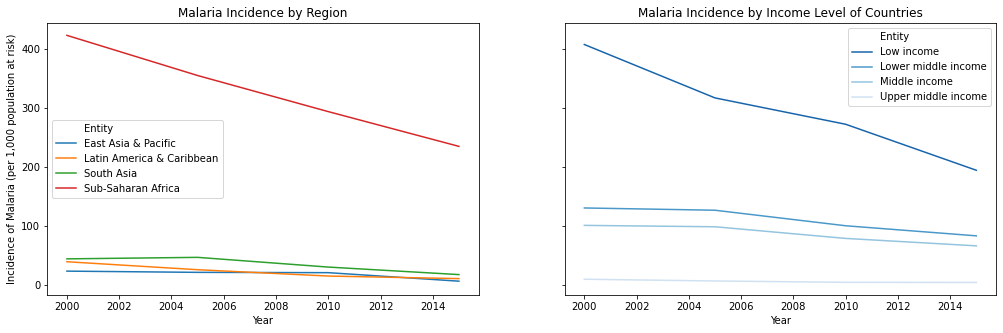

In [65]:
# defining region and income based on rows in dataset
region = ["East Asia & Pacific", "South Asia", "Sub-Saharan Africa", "Latin America & Caribbean"]
income = ["Low income", "Middle income", "Lower middle income", "Upper middle income"]

df_region = df_inc[df_inc.Entity.isin(region)]
df_income = df_inc[df_inc.Entity.isin(income)]

fig, ax = plt.subplots(1, 2, figsize=(17,5), sharey=True)

g = sns.lineplot(
    data = df_region, 
    x = 'Year',
    y = 'Incidence',
    hue = 'Entity',
    ax = ax[0]
)

g.set(xlabel ="Year", ylabel = "Incidence of Malaria (per 1,000 population at risk)", title ='Malaria Incidence by Region')

g2 = sns.lineplot(
    data = df_income, 
    x = 'Year',
    y = 'Incidence',
    hue = 'Entity',
    ax = ax[1],
    palette="Blues_r"
)

g2.set(xlabel ="Year", ylabel = "", title ='Malaria Incidence by Income Level of Countries')

plt.show()

I wanted to create a map, so I needed the data to be aggregated by continents. Using a crosstable with country codes and continent values, I merged the incidence dataset with the crosstable using the country codes. I then, subset the data to Africa to view change in incidence over time among African countries.  
  
I chose to use the plotly library, because I wanted to make an interactive plot and plotly works well for this task. First, I created a dataset for each year in the dataset and added each year's data to a list that will be used to create the slider. The next step was to create the slider. I referenced this blog post to create the slider object https://medium.com/@anikanacey/adventures-in-plotly-an-interactive-choropleth-map-646f6a2f4e3a. Lastly, I created the image (the continent of Africa with countries) for the data to plotted on and used plotly's offline module to call the plot. 

In [66]:
url2 = "https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv"
df_cont = pd.read_csv(url2)
df_cont = df_cont[["name", "alpha-3", "region"]]
df_cont = df_cont.rename(columns = {'alpha-3': 'Code'})

In [67]:
df_map = (df_inc[df_inc.Code.notnull()])
df_africa = pd.merge(df_map, df_cont, how="left", on="Code")
df_africa = df_africa.loc[df_africa['region']== "Africa"]

In [68]:
slider_data = []
year_steps = []

for year in df_africa['Year'].unique():
    df_year = df_africa.loc[df_africa['Year'] == year]
    df_year = df_year.astype(str)

    one_year = dict(
        type='choropleth',
        locations = df_year['name'],
        z=df_year['Incidence'].astype(float),
        locationmode='country names',
        colorscale = "oranges", 
        colorbar= {'title':'Malaria Incidence (per 1,000 population at risk)'})

    slider_data.append(one_year)


for i in range(len(slider_data)):
    step = dict(method='restyle',
                args=['visible', [False] * len(slider_data)],
                label='{}'.format(5*i + 2000))
    step['args'][1][i] = True
    year_steps.append(step)

sliders = [dict(active=0, pad={"t": 1}, steps=year_steps)]    

layout = dict(title ='Incidence of Malaria in Africa since 2000', 
              geo=dict(scope='africa', showcountries = True, projection={'type': 'equirectangular'}),
              sliders=sliders)

fig_africa = dict(data=slider_data, layout=layout)

offline.iplot(fig_africa, show_link = True)

This third and final plot illustrates deaths from Malaria by continent over time. I once again used the crosstable with country codes and continents to aggregate the deaths dataset by continent. 

In [69]:
df2_deaths = df_deaths[df_deaths.Code.notnull()]
df_combine = pd.merge(df2_deaths, df_cont, how="left", on="Code")
df_combine = df_combine.dropna()

In [70]:
fig_cont = px.area(df_combine, 
               x="Year", y="Deaths",
               color="region", line_group="name", 
               labels={
                     "region": "Continent",
                     "Deaths": "Deaths (per 100,000 people)"
                 },
                title="Deaths from Malaria by Continent over Time")

fig_cont.update_layout(
    autosize=False,
    width=900,
    height=700)

offline.iplot(fig2)